# Example *ppar* for RIBF data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ppar as ppar

In [2]:
INCOMING = '84Ge'
OUTGOING = '83Ge'

#Monte Carlo samples for
#subtraction of bg from peak
MC_NUM   = int(1e4)

#Gate energies
ENERGIES = np.array([{'peak':1045,'bg':1080},
                     {'peak':1238,'bg':1290},
                     {'peak':1359,'bg':1410},
                     {'peak':2113,'bg':2245},
                    ])

#Definition of beam, target, and outgoing fragment.
#This will mainly be needed later for automated
#stopping calculations using Atima.
beam     = {'name':'84Ge','Z':32,'A':84,'mass':83.937575}
product  = {'name':'83Ge','Z':32,'A':83,'mass':82.934539}

target   = {'name': '9Be','Z': 4,'A': 9,'mass': 9.0121821,
            'thickness':1108.8,'density':1.848}

#for plotting
Dic_colors  = {0:'black',1:'firebrick',2:'orange',3:'royalblue',4:'forestgreen'}
Dic_markers = {0:'v',1:'x',2:'.',3:'s',4:'d'}

## Data preparation

Histograms for unreacted and reaction setting are loaded from *.root* files.
Data is extracted and plotted. Momentum distributions from background cuts
are subtracted from cuts on depopulating transitions.
For the sake of simplicty, equal $\gamma$-ray detection efficiencies are assumed.

### Data

In [3]:
hists       = {key:{} for key in [INCOMING,OUTGOING]}

for key in hists.keys():

    file = 'hist_ppar_in%s_out%s.root'% (INCOMING,key)

    #inclusive distribution
    hists[key]['incl'] = ppar.spectrum(file,'ppar_beta/ppar_rest_beta;1',mc_num=MC_NUM)

    #select reacted setting
    if key == INCOMING:
        continue

    for comb in ENERGIES:
        for en in comb.values():

            hists[key][en] = ppar.spectrum(file,'ppar_beta/ppar_rest_beta_%i;1'% en,mc_num=MC_NUM)

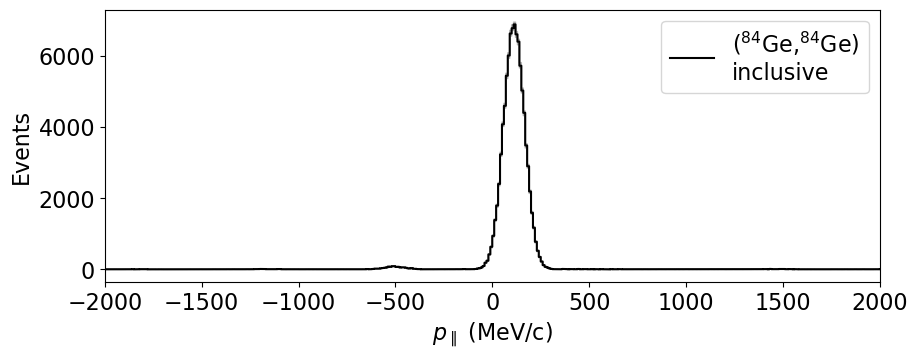

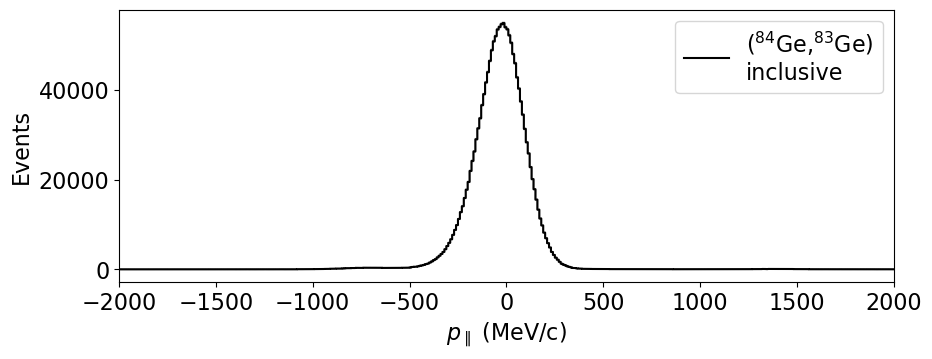

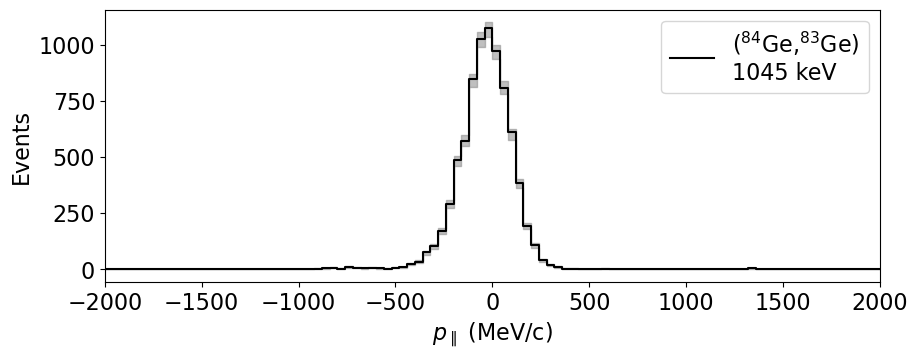

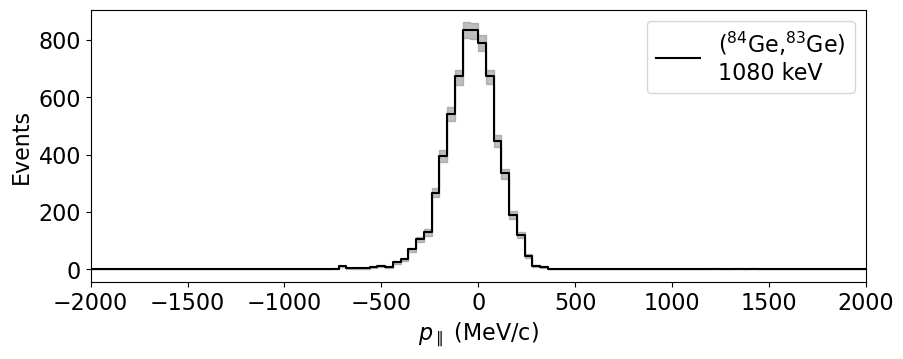

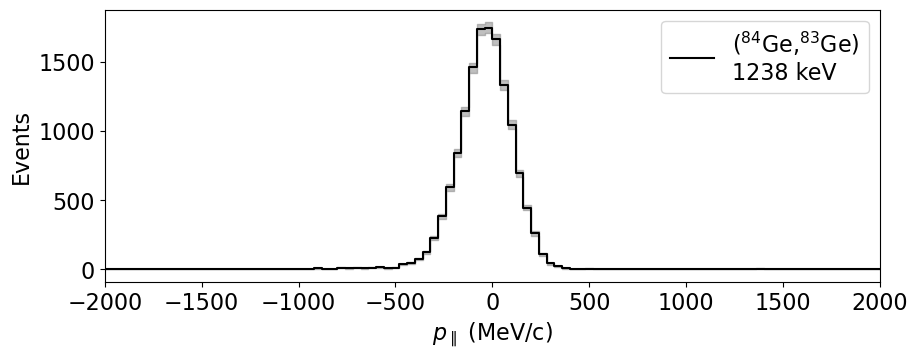

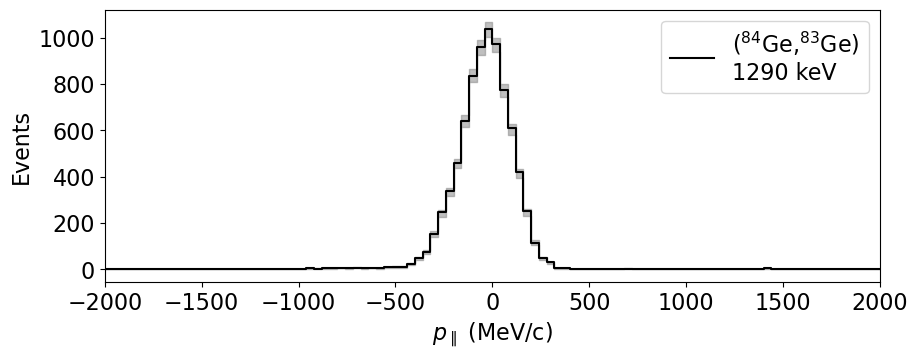

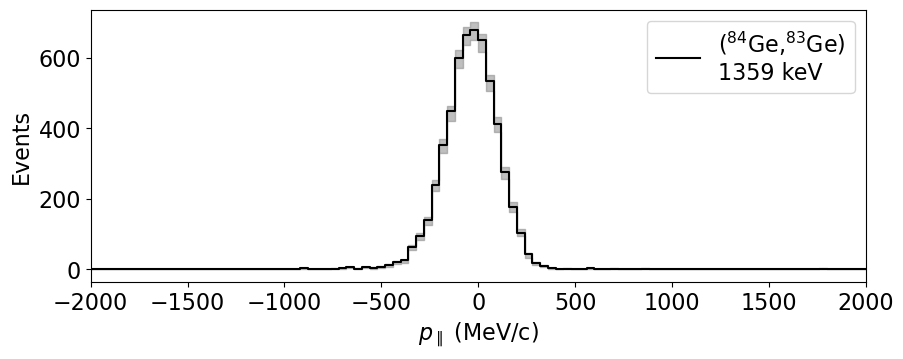

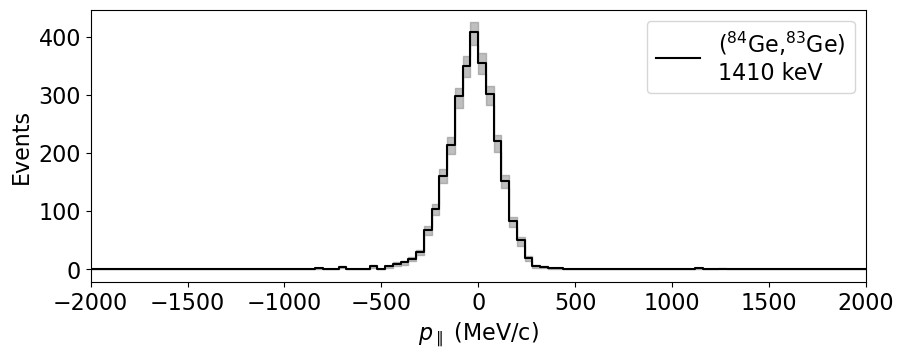

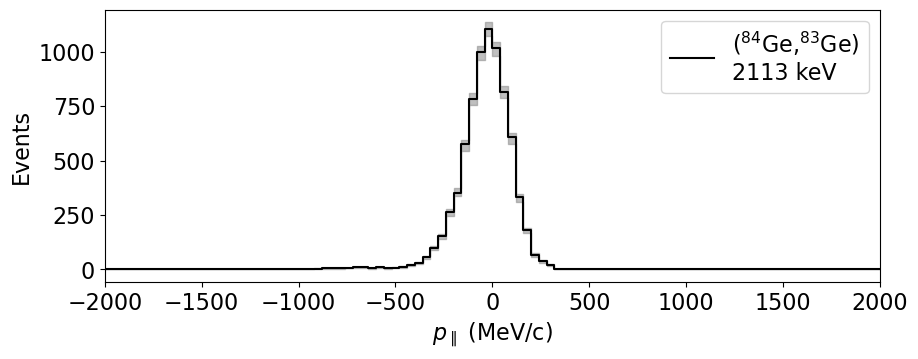

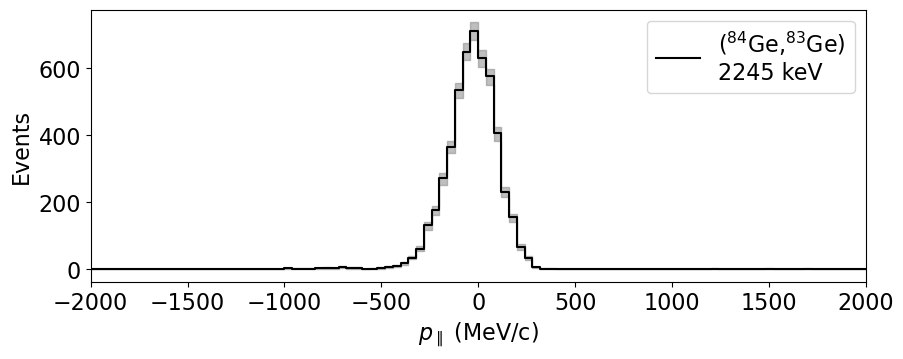

In [4]:
for key in hists.keys():
    for name,hist in hists[key].items():

        name = '\ninclusive' if name == 'incl' else '\n%i keV'% name
        name = '(%s,%s)'% (ppar.name_nucl(INCOMING),ppar.name_nucl(key)) + name

        fig,ax = hist.plot(xlim=[-2000,2000],label=name)

### Efficiency

In [5]:
for comb in ENERGIES:
    for en in comb.values():

        #This must be replaced by real efficiencies!
        eff = np.ones(MC_NUM)

        hists[OUTGOING][en].values /= eff

### Background subtraction

In [6]:
hists_corr = {}

for comb in ENERGIES:

    hists_corr[comb['peak']]         = hists[OUTGOING][comb['peak']].copy()
    hists_corr[comb['peak']].values -= hists[OUTGOING][comb['bg']].values

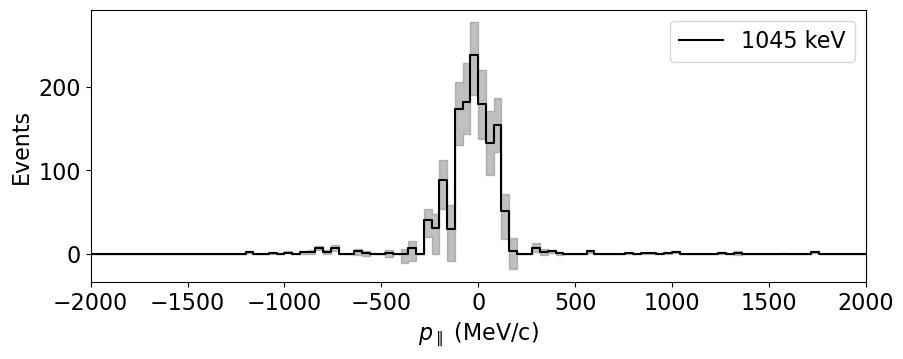

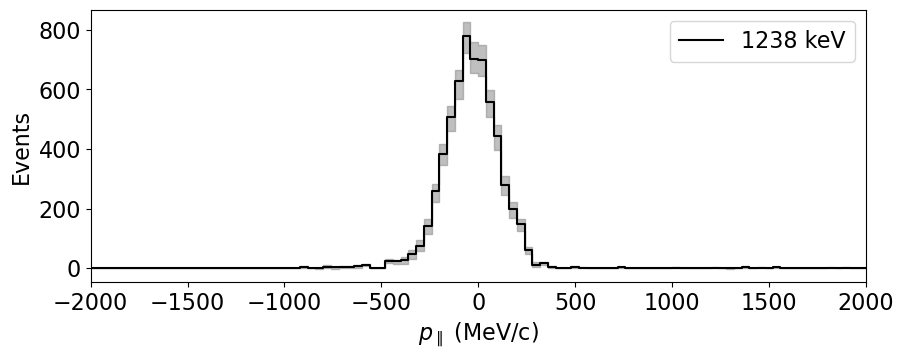

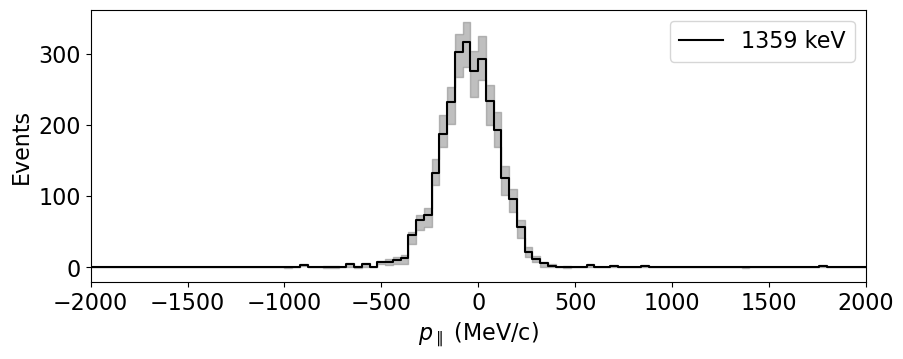

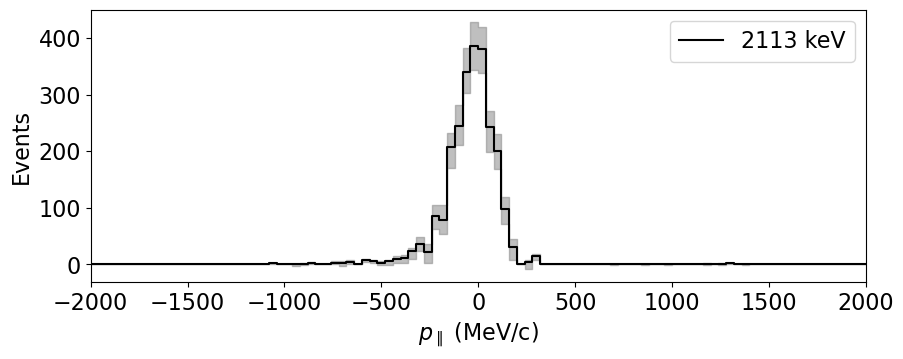

In [7]:
for en in ENERGIES:

    en = en['peak']

    #fig,ax = ppar.plot_hist(hists_corr[en],label='%i keV'% en)

    #add uncertainty bands
    #plot_mean = np.mean(hists_corr[en]['mc_values'],axis=1)
    #plot_std  = np.std(hists_corr[en]['mc_values'],axis=1)

    #ax.fill_between(hists_corr[en]['x_centers'],
    #                plot_mean-plot_std,plot_mean+plot_std,
    #                step='mid',color='grey',alpha=0.5
    #               )

    #ax.set_xlim(-2000,2000);

    #ax.set_xlabel(r'$p_{\parallel}$ (MeV/c)', fontsize=16);

    hists_corr[en].plot(xlim=[-2000,2000],label='%i keV'% en)

## Theory

Initialization of *ppar* with details on beam, target, and outgoing fragment.
This information will in the future be used for stopping calculations 
(similar to the NSCL part of the *ppar* code).
For now the momentum difference due to the different stopping of beam and fragment
in the target has to be calculated manually using LISE++.

Inclusive parallel momentum distributions from unreacted and reaction settings 
can be loaded and fitted to center them around zero.
Unsing the 'func' argument, the fit function can be specified (default *gaussian*).
Common functions such as standard and skewed Gaussians are already implemented.
For more complicated fits a tailored minimization function for the fit
can be provided via the 'minimizer' argument (see the NSCL example for more information).

Convolution of parallel momentum distributions obtained from theory with a rectangular function
accounting for the momentum difference due to the uncertain reaction position and the
profile from the unreacted beam setting.

In [8]:
ppar_mwe = ppar.ppar_RIBF(beam,target,product,verbose=True,)

##############################
#       ppar convolver       #
#            RIBF            #
##############################

########################
#  Input               #
########################

                    Beam           Target         Product        
---------------------------------------------------------
name                84Ge           9Be            83Ge           
A                   84             9              83             
Z                   32             4              32             
mass (u)            83.9376        9.0122         82.9345        
ion mass (u)        83.9200        9.0100         82.9170        
density (g/cm3)                    1.8480                        
d (mg/cm2)                         1108.8                        
d (µm)                             6000.0                        



Calculate the momentum difference due to the unknown reaction position along the target with LISE++
and insert the symmetrized difference, i.e. in the form [-a,a] here.
In the future this might be done automatically using more comprehensive Atima calculations.

In [9]:
p_diff = [-30,30] #example value

#ppar_mwe.calc_stopping(p_diff)
ppar_mwe.set_p_range(p_diff)

### Unreacted

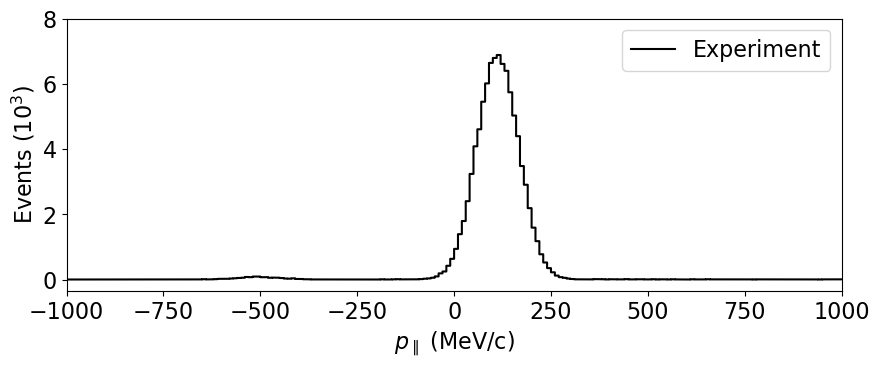

In [10]:
ppar_mwe.load_unreacted(file='hist_ppar_in%s_out%s.root'% (INCOMING,INCOMING),
                        hist='ppar_beta/ppar_rest_beta;1',
                        rebin=1
                       )

ppar_mwe.plot_unreacted(xlim=[-1000,1000]);

Using fit function gaussian.
Using minimizer func_minimize.


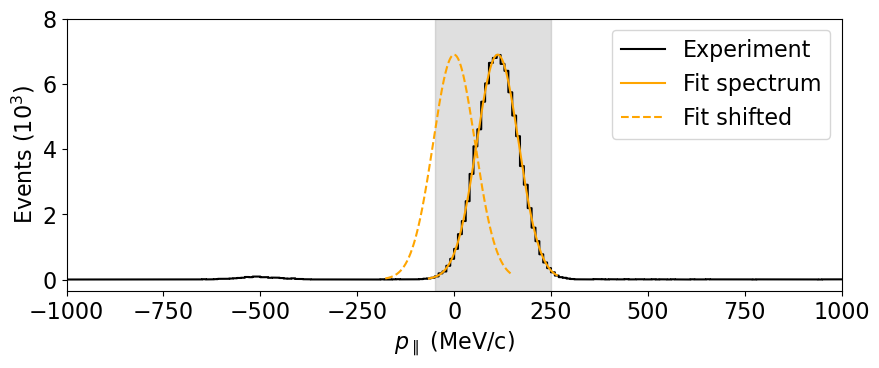

In [11]:
x0 = [1e8,0,10]

#use default gaussian for fit
ppar_mwe.fit_unreacted(fit_range=[-50,250],x0=x0)
ppar_mwe.plot_unreacted(xlim=[-1000,1000]);

In [12]:
ppar_mwe.fit_res_unreac.x

array([9.37501326e+05, 1.12535372e+02, 5.42244134e+01])

### Reaction setting

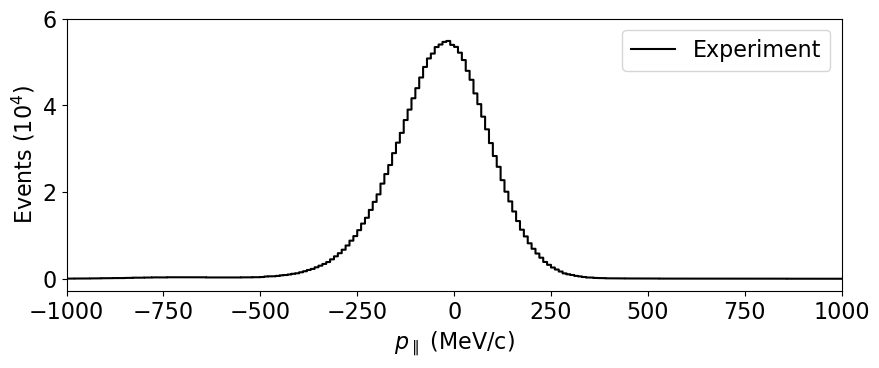

In [13]:
ppar_mwe.load_reacted(file='hist_ppar_in%s_out%s.root'% (INCOMING,OUTGOING),
                      hist='ppar_beta/ppar_rest_beta;1',
                      rebin=1
                     )

ppar_mwe.plot_reacted(xlim=[-1000,1000]);

Using fit function skewed_gaussian.
Using minimizer func_minimize.


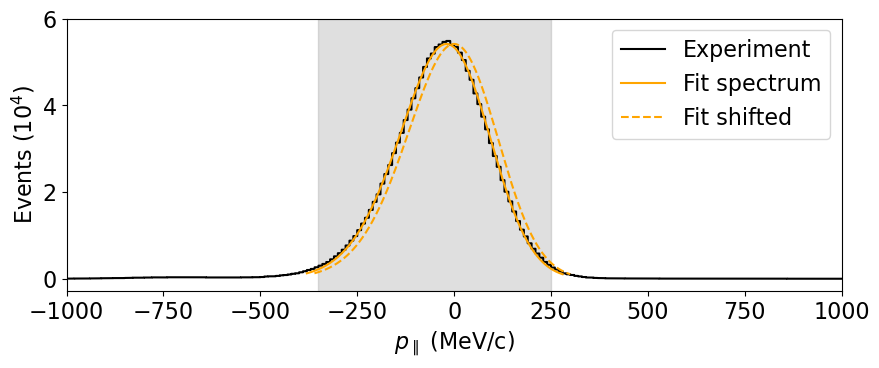

In [14]:
x0 = [1e8,10,0,-1]

ppar_mwe.fit_reacted(fit_range=[-350,250],x0=x0,func=ppar.skewed_gaussian)
ppar_mwe.plot_reacted(xlim=[-1000,1000]);

In [15]:
ppar_mwe.fit_res_reac.x

array([ 1.59523573e+07,  1.53119208e+02,  6.23824830e+01, -1.27314814e+00])

### Comparison

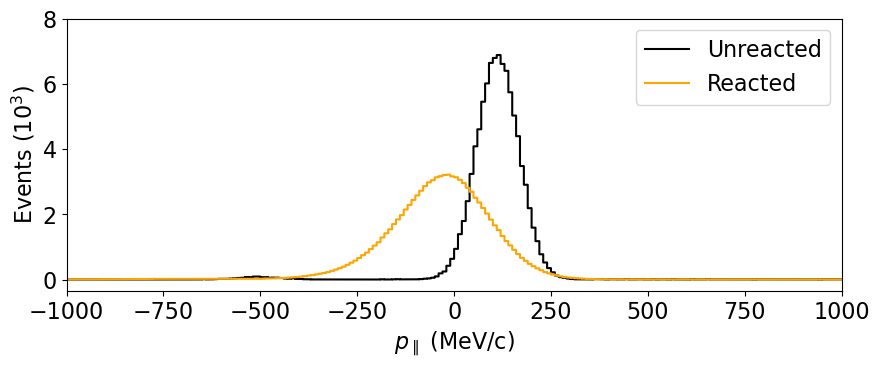

In [16]:
fig,ax = ppar_mwe.plot_unreacted(plot_fit=False,xlim=[-1000,1000],label='Unreacted');

x_plot = ppar_mwe.spec_reac.centers
y_plot = ppar_mwe.spec_reac.values
scale  = np.sum(ppar_mwe.spec_unreac.values)/np.sum(ppar_mwe.spec_reac.values)

ax.step(x_plot,scale*y_plot,where='mid',color='orange',label='Reacted')

plt.legend(fontsize=16)

### Convolution of theoretical distributions

In [17]:
theo_mwe = {name:ppar.state(ppar_mwe,'pparGe83_%s.dat'% name) for name in ['3s1','2d5','1g9']}

Dic_labels = {'3s1':r'$3s_{1/2}$','2d5':r'$2d_{5/2}$','1g9':r'$1g_{9/2}$'}

#### $3s_{1/2}$

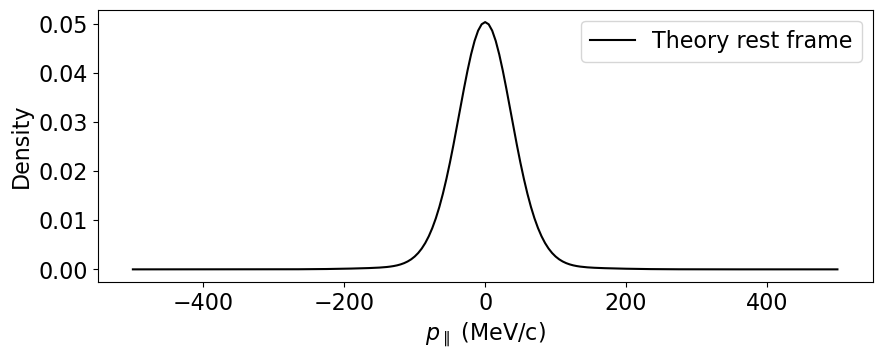

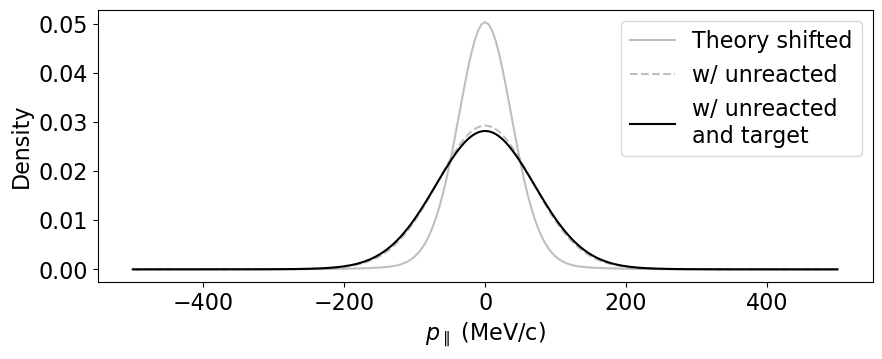

In [18]:
ORB = '3s1'

theo_mwe[ORB].plot_theory();
theo_mwe[ORB].convolve_theory();
theo_mwe[ORB].plot_theory();

#### $2d_{5/2}$

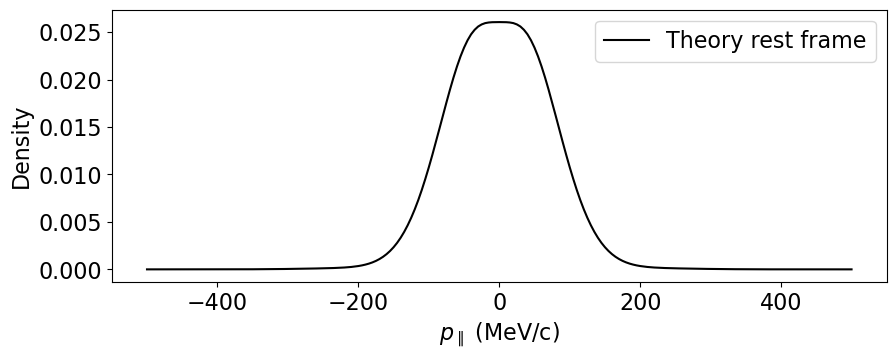

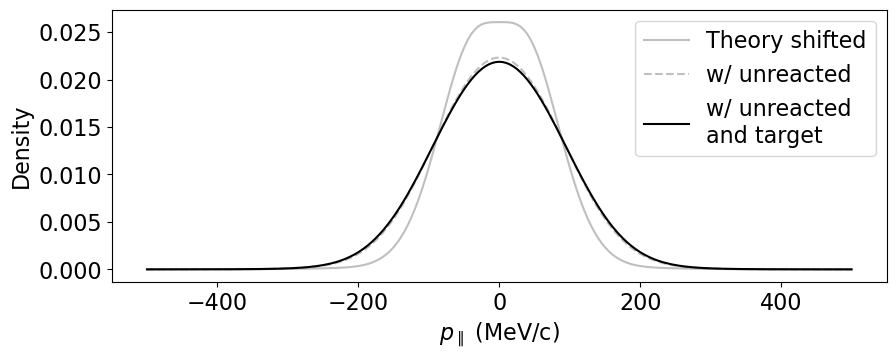

In [19]:
ORB = '2d5'

theo_mwe[ORB].plot_theory();
theo_mwe[ORB].convolve_theory();
theo_mwe[ORB].plot_theory();

#### $1g_{9/2}$

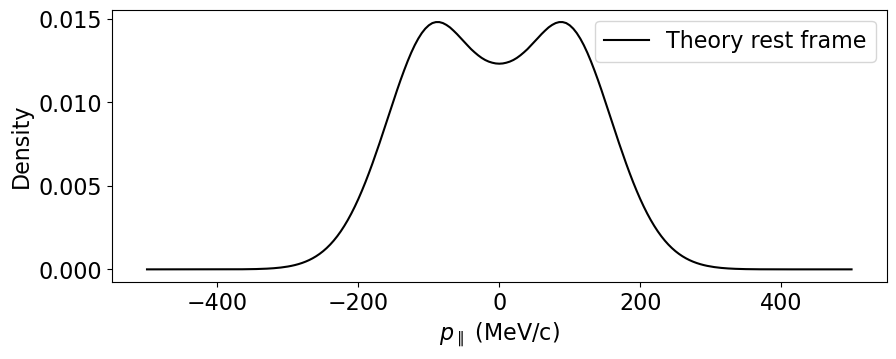

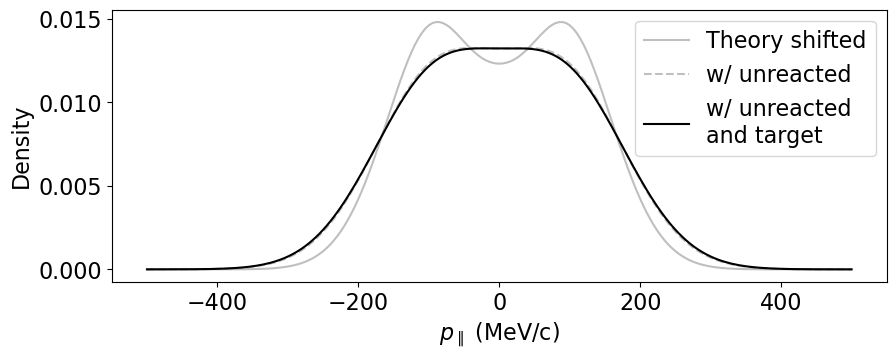

In [20]:
ORB = '1g9'

theo_mwe[ORB].plot_theory();
theo_mwe[ORB].convolve_theory();
theo_mwe[ORB].plot_theory();

## Comparison between theory and data

Comparison of background-subtracted, experimental parallel momentum distributions to
convolved distributions from theory. 

The experimental distribution can be rebinned if needed and (almost) empty bins can be cut
with the *threshold* argument. The theoretical distribution is scaled to the maximum bin content
of the experimental distribution using the *scale_theory* method.

If possible the *plot_hist* method will include the scaled theoretical distribution.
This behavior can be suppressed by setting the *plot_theory* argument to *False*.
The plots can be somewhat modified using the appropriate keyword arguments.
For more customization the *figure* and *axes* objects are returned.

### 1238 keV

In [21]:
EN = 1238

for orb in theo_mwe.keys():

    theo_mwe[orb].rebin_hist(hists_corr[EN],
                             rebin=2,
                             threshold=100,
                             )
    #theo_mwe[orb].plot_hist(xlim=[-1000,1000],ylim=[-10,600]);

    theo_mwe[orb].scale_theory()
    #theo_mwe[orb].plot_hist(xlim=[-1000,1000],ylim=[-10,1000]);

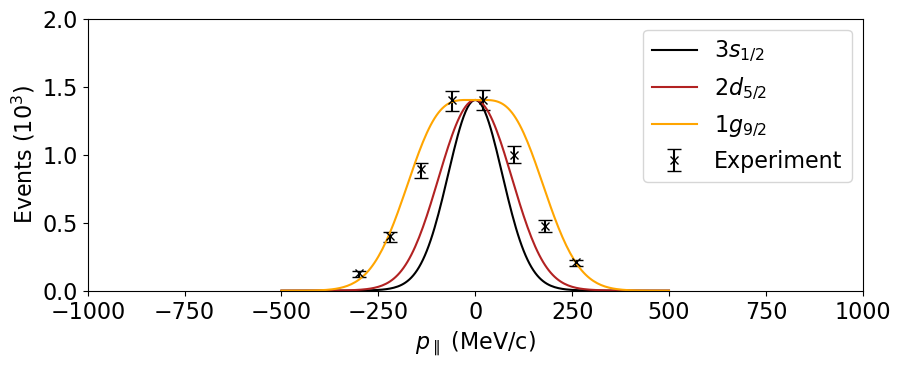

In [22]:
#Plot of experimental parallel momentum distribution with all distributions from theory.
fig,ax = theo_mwe['3s1'].plot_hist(plot_theory=False,xlim=[-1000,1000]);

for num,orb in enumerate(theo_mwe.keys()):

    x_plot = theo_mwe[orb].ppar_theo['tail_target'].centers
    y_plot = theo_mwe[orb].ppar_theo['tail_target'].values
    scale  = theo_mwe[orb].fit_res
    
    ax.plot(x_plot,scale*y_plot,color=Dic_colors[num],label=Dic_labels[orb])

    ax.legend(fontsize=16)

### 1359 keV

In [23]:
EN = 1359

for orb in theo_mwe.keys():

    theo_mwe[orb].rebin_hist(hists_corr[EN],
                             rebin=2,
                             threshold=50,
                             )
    #theo_mwe[orb].plot_hist(xlim=[-1000,1000],ylim=[-10,600]);

    theo_mwe[orb].scale_theory()
    #theo_mwe[orb].plot_hist(xlim=[-1000,1000],ylim=[-10,1000]);

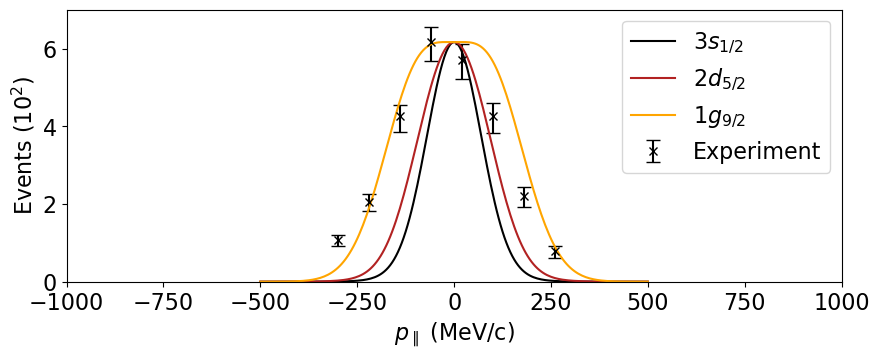

In [24]:
#Plot of experimental parallel momentum distribution with all distributions from theory.
fig,ax = theo_mwe['3s1'].plot_hist(plot_theory=False,xlim=[-1000,1000]);

for num,orb in enumerate(theo_mwe.keys()):

    x_plot = theo_mwe[orb].ppar_theo['tail_target'].centers
    y_plot = theo_mwe[orb].ppar_theo['tail_target'].values
    scale  = theo_mwe[orb].fit_res
    
    ax.plot(x_plot,scale*y_plot,color=Dic_colors[num],label=Dic_labels[orb])

    ax.legend(fontsize=16)

### 2113 keV

In [25]:
EN = 2113

for orb in theo_mwe.keys():

    theo_mwe[orb].rebin_hist(hists_corr[EN],
                             rebin=1,
                             threshold=10,
                             )
    #theo_mwe[orb].plot_hist(xlim=[-1000,1000],ylim=[-10,600]);

    theo_mwe[orb].scale_theory()
    #theo_mwe[orb].plot_hist(xlim=[-1000,1000],ylim=[-10,1000]);

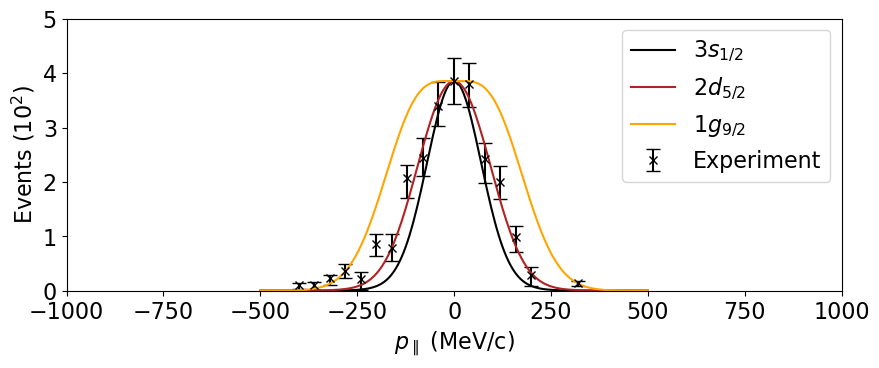

In [26]:
#Plot of experimental parallel momentum distribution with all distributions from theory.
fig,ax = theo_mwe['3s1'].plot_hist(plot_theory=False,xlim=[-1000,1000]);

for num,orb in enumerate(theo_mwe.keys()):

    x_plot = theo_mwe[orb].ppar_theo['tail_target'].centers
    y_plot = theo_mwe[orb].ppar_theo['tail_target'].values
    scale  = theo_mwe[orb].fit_res
    
    ax.plot(x_plot,scale*y_plot,color=Dic_colors[num],label=Dic_labels[orb])

    ax.legend(fontsize=16)